# Visualisations of the Tracked _Real_ Events (OSTIA Observations) using `plotX`
cf. Plots when exchange for Basic Tracking (i.e. `extreme_events_basic_gridded.zarr`)

In [1]:
from getpass import getuser
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Video

import marEx
import marEx.helper as hpc

In [2]:
# Directories
scratch_dir = Path("/scratch") / getuser()[0] / getuser()  # Lustre Scratch Directory

file_name_extremes = scratch_dir / "mhws" / "extremes_binary_gridded_shifting_hobday.zarr"
file_name_events = scratch_dir / "mhws" / "extreme_events_merged_gridded_shifting.zarr"
plot_dir = scratch_dir / "mhws" / "plots"

In [ ]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=32, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

In [4]:
# Import Tracked Extremes DataSet
extremes_ds = xr.open_zarr(str(file_name_extremes), chunks={})
extremes_ds

<xarray.Dataset> Size: 50GB
Dimensions:         (time: 9282, lat: 720, lon: 1440, dayofyear: 366)
Coordinates:
  * dayofyear       (dayofyear) int32 1kB 1 2 3 4 5 6 ... 362 363 364 365 366
  * lat             (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon             (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time            (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-0...
Data variables:
    dat_anomaly     (time, lat, lon) float32 38GB dask.array<chunksize=(25, 720, 1440), meta=np.ndarray>
    extreme_events  (time, lat, lon) bool 10GB dask.array<chunksize=(25, 720, 1440), meta=np.ndarray>
    mask            (lat, lon) bool 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    thresholds      (lat, lon, dayofyear) float32 2GB dask.array<chunksize=(90, 180, 46), meta=np.ndarray>
Attributes:
    max_anomaly:           5.0
    method_anomaly:        shifting_baseline
    method_extreme:        hobday_extreme
    method_percentile:     approximate
    precision:             0.01
    preprocessing_steps:   ['Rolling climatology using 15 years', 'Smoothed w...
    smooth_days_baseline:  21
    threshold_percentile:  95
    window_days_hobday:    11
    window_year_baseline:  15

In [5]:
# Import Tracked Extremes DataSet
extreme_events_ds = xr.open_zarr(str(file_name_events), chunks={})
extreme_events_ds

<xarray.Dataset> Size: 45GB
Dimensions:       (ID: 9290, time: 9282, lat: 720, lon: 1440, component: 2,
                   sibling_ID: 15)
Coordinates:
  * ID            (ID) int32 37kB 1 2 3 4 5 6 ... 9285 9286 9287 9288 9289 9290
  * component     (component) int64 16B 0 1
  * lat           (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon           (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time          (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-...
Dimensions without coordinates: sibling_ID
Data variables:
    ID_field      (time, lat, lon) int32 38GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    area          (time, ID) float32 345MB dask.array<chunksize=(1, 9290), meta=np.ndarray>
    centroid      (component, time, ID) float32 690MB dask.array<chunksize=(1, 1, 9290), meta=np.ndarray>
    global_ID     (time, ID) int32 345MB dask.array<chunksize=(1, 9290), meta=np.ndarray>
    merge_ledger  (time, ID, sibling_ID) int32 5GB dask.array<chunksize=(1, 9290, 15), meta=np.ndarray>
    presence      (time, ID) bool 86MB dask.array<chunksize=(1, 9290), meta=np.ndarray>
    time_end      (ID) datetime64[ns] 74kB dask.array<chunksize=(9290,), meta=np.ndarray>
    time_start    (ID) datetime64[ns] 74kB dask.array<chunksize=(9290,), meta=np.ndarray>
Attributes: (12/14)
    N_events_final:              9291
    N_objects_filtered:          131687
    N_objects_prefiltered:       174850
    R_fill:                      12
    T_fill:                      4
    accepted_area_fraction:      0.9862115802332532
    ...                          ...
    area_threshold (cells):      600
    multi_parent_merges:         13852
    nn_partitioning:             1
    overlap_threshold:           0.25
    preprocessed_area_fraction:  0.38775179242158936
    total_merges:                38017

In [6]:
# Extract the Events ID Field
ID_field = extreme_events_ds.ID_field
ID_field

<xarray.DataArray 'ID_field' (time: 9282, lat: 720, lon: 1440)> Size: 38GB
dask.array<open_dataset-ID_field, shape=(9282, 720, 1440), dtype=int32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-31T12...

## Make a Movie using `plotX.animate`
N.B.: Making `dask`-powered movies using `animate()` cannot be threaded !

In [ ]:
# Choose a subset of the ID field
extreme_events_ds_subset = extreme_events_ds.sel(time=slice("2020-01-01", "2022-05-31"))
ID_field_subset = extreme_events_ds_subset.ID_field
centroids_subset = extreme_events_ds_subset.centroid

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True)
movie_ID = ID_field_subset.plotX.animate(config, plot_dir=plot_dir, file_name="movie_ID_field_gridded", centroids=centroids_subset)

In [10]:
Video("../../media/movie_ID_field_gridded.mp4", width=640, height=480, embed=False)

In [ ]:
# Plot the anomalous temperature field

anomaly_subset = extremes_ds.dat_anomaly.sel(time=slice("2020-01-01", "2022-05-31"))
anomaly_hot = anomaly_subset.where(anomaly_subset > 0, 0)

extreme_events_ds_subset = extreme_events_ds.sel(time=slice("2020-01-01", "2022-05-31"))
ID_field_subset = extreme_events_ds_subset.ID_field
centroids_subset = extreme_events_ds_subset.centroid

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(var_units="Temperature Anomaly", cmap="inferno", cperc=[0, 98], projection=ccrs.PlateCarree())
movie_anomaly = anomaly_hot.plotX.animate(
    config,
    plot_dir=plot_dir,
    file_name="movie_anomaly_gridded",
    centroids=centroids_subset,
    object_ids=ID_field_subset
)

In [11]:
Video("../../media/movie_anomaly_gridded.mp4", width=640, height=480, embed=False)

cf. "Basic" Tracking, i.e. the current standard method in the literature, involving _No_ temporal gap filling, _No_ merging/splitting and _No_ independent event tracking. 

In [ ]:
# Choose a subset of the "Basic" ID field
ID_field_basic_subset = xr.open_zarr(str(file_name_events).replace("merged", "basic"), chunks={}).ID_field.sel(
    time=slice("2020-01-01", "2022-05-31")
)

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True)
movie_ID_basic = ID_field_basic_subset.plotX.animate(config, plot_dir=plot_dir, file_name="movie_ID_field_basic_gridded")

In [12]:
Video("../../media/movie_ID_field_basic_gridded.mp4", width=640, height=480, embed=False)

## Plot Consecutive Days of Extreme Events

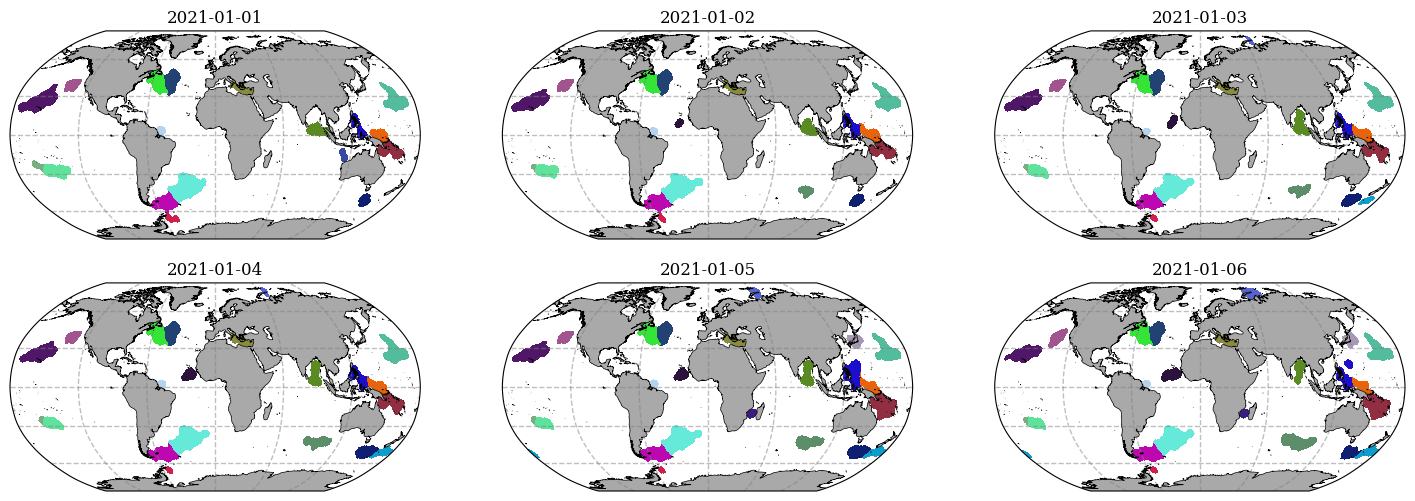

In [13]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice("2021-01-01", "2021-01-06"))

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True)
fig, ax = ID_field_subset.plotX.multi_plot(config, col="time", col_wrap=3);

## Plot Consecutive Months of Extreme Events

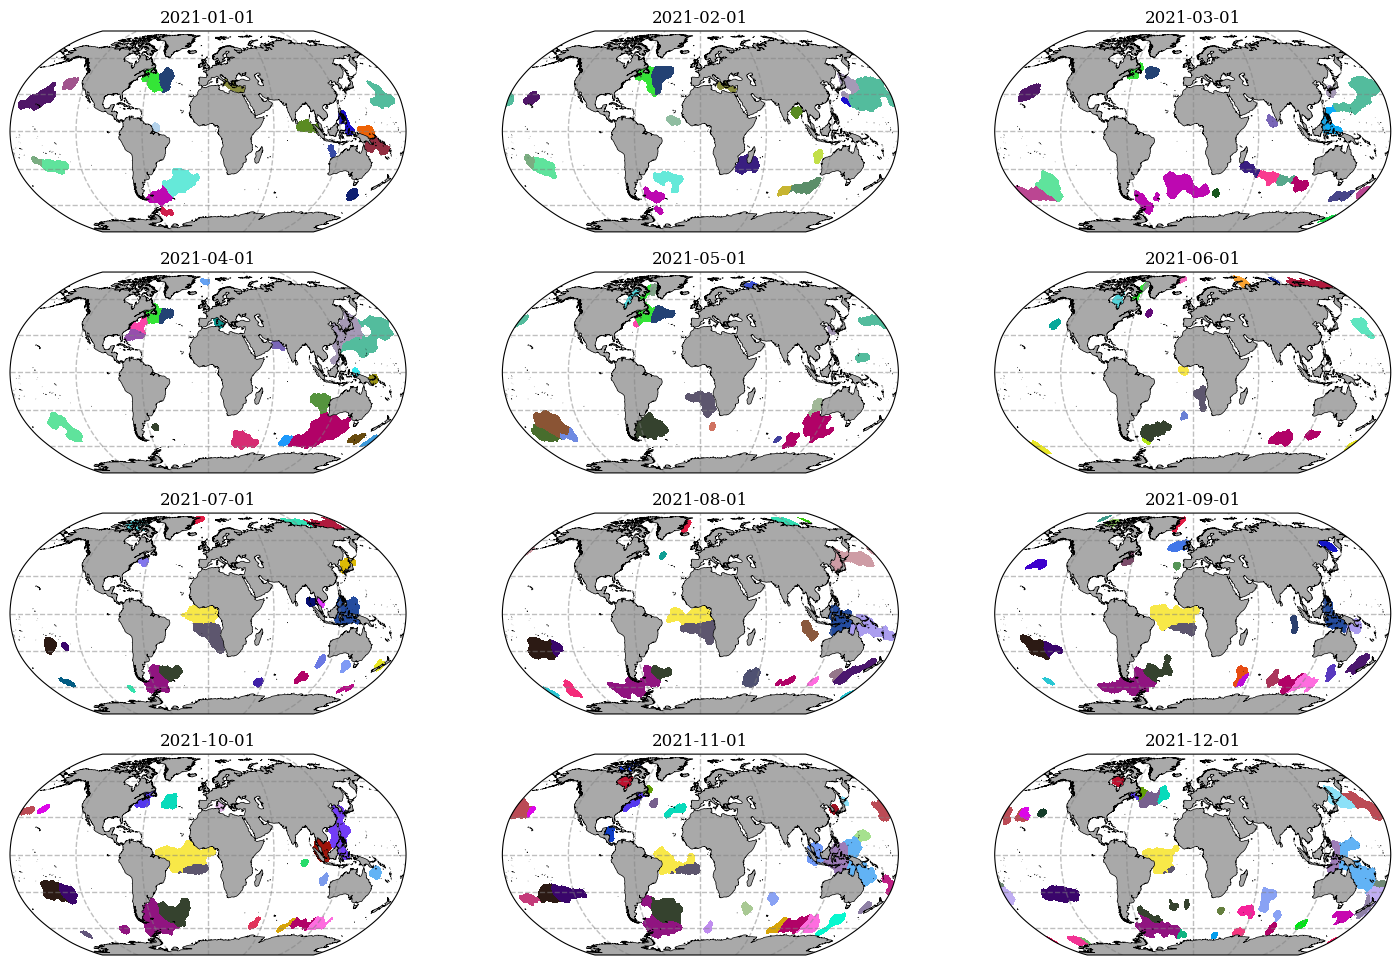

In [14]:
# Choose the first day of each month from a subset of the ID field
ID_field_subset_day1 = ID_field.sel(time=slice("2021-01-01", "2021-12-31")).resample(time="MS").nearest()

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True)
fig, ax = ID_field_subset_day1.plotX.multi_plot(config, col="time", col_wrap=3);

## Plot Global Extreme Event Frequency

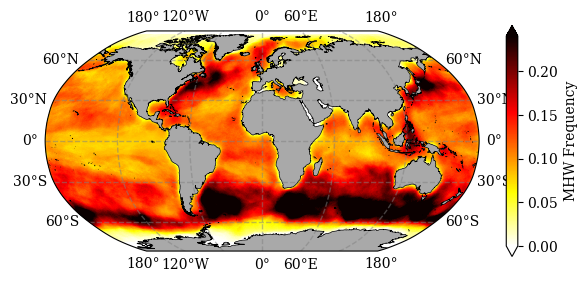

In [15]:
# Calculate the frequency of Event Occurrence
event_frequency = (ID_field > 0).mean("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True)
fig, ax, im = event_frequency.plotX.single_plot(config)

## Plot Seasonal Extreme Event Frequency

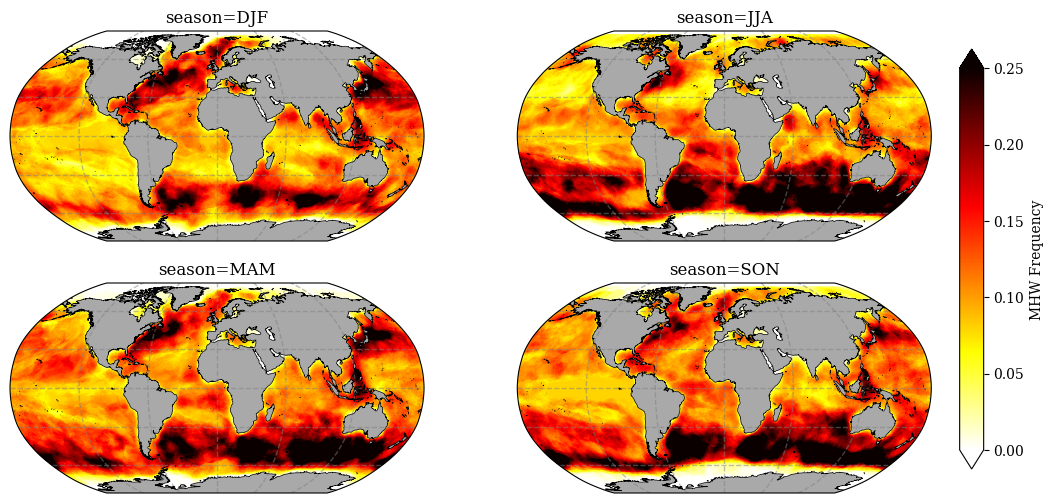

In [16]:
# Calculate the frequency of Event Occurrence per season
seasonal_frequency = (ID_field > 0).groupby("time.season").mean(dim="time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True)
fig, ax = seasonal_frequency.plotX.multi_plot(config, col="season", col_wrap=2);

## Find & Plot a Few of the Longest Events (and **The Blob**!)

In [17]:
events_duration = extreme_events_ds.time_end - extreme_events_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(
        f"ID: {ID:<6}   Start Day: {extreme_events_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}  -->  Duration: {events_duration.sel(ID=ID).dt.days.values:<4} days"
    )

ID: 5911     Start Day: 2013-10-20  -->  Duration: 1443 days
ID: 6788     Start Day: 2016-03-10  -->  Duration: 978  days
ID: 4814     Start Day: 2010-07-23  -->  Duration: 941  days
ID: 6525     Start Day: 2015-06-09  -->  Duration: 918  days
ID: 6710     Start Day: 2015-12-16  -->  Duration: 882  days
ID: 6235     Start Day: 2014-09-02  -->  Duration: 805  days
ID: 7886     Start Day: 2019-02-10  -->  Duration: 652  days
ID: 7806     Start Day: 2018-12-15  -->  Duration: 645  days
ID: 6272     Start Day: 2014-10-09  -->  Duration: 625  days
ID: 311      Start Day: 1997-09-29  -->  Duration: 596  days


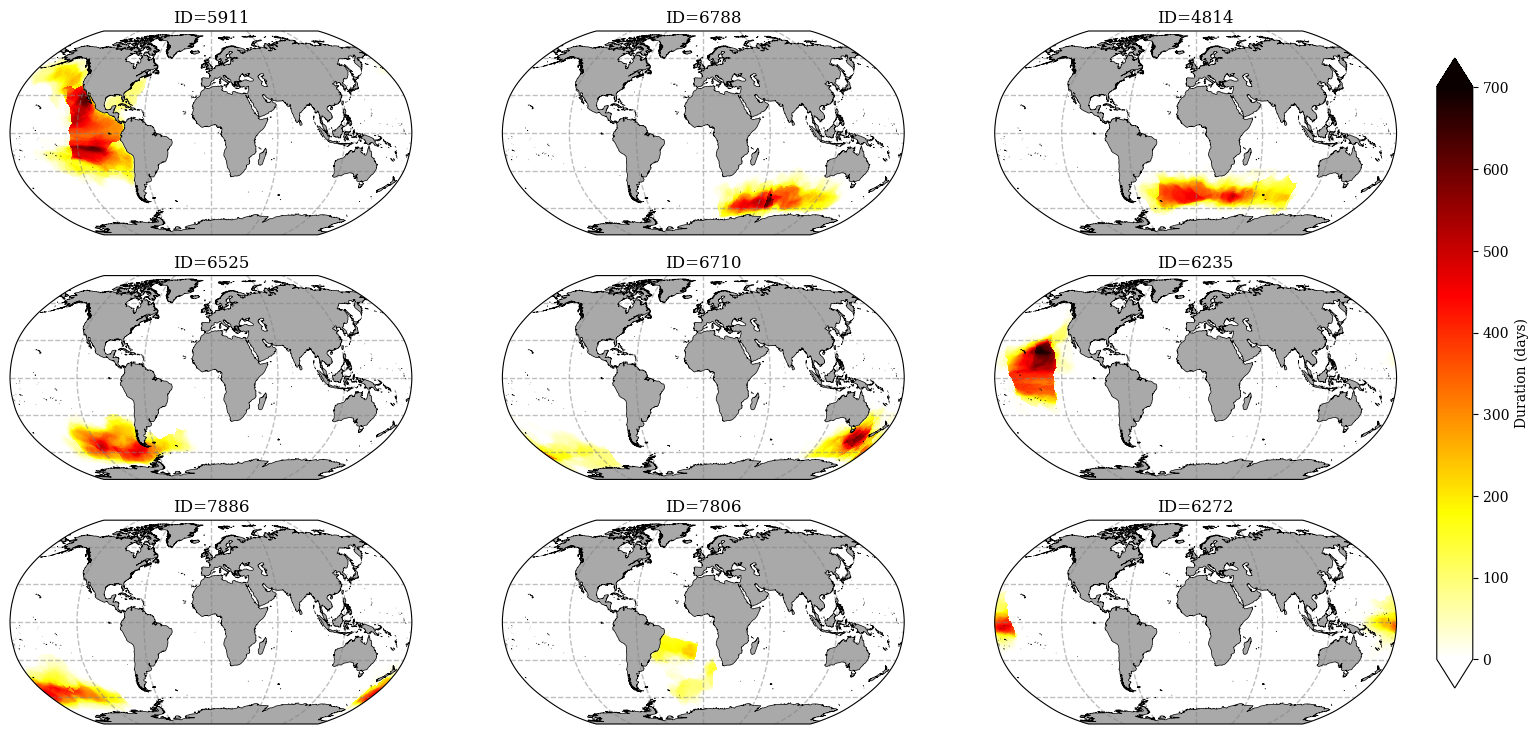

In [18]:
# Calculate the local duration of the longest events
long_events = ID_field == (longest_events[:9]).chunk({"ID": 1})
long_events_local_duration = (long_events > 0).sum("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="Duration (days)", cmap="hot_r", cperc=[0, 100])
fig, ax = long_events_local_duration.plotX.multi_plot(config, col="ID", col_wrap=3);

## ID Maximum and Mean Event Area

In [7]:
areas_max = extreme_events_ds.area.max().compute()
print(f"Maximum object area: {areas_max.values:.0f} km²")

areas_mean = extreme_events_ds.area.mean().compute()
print(f"Mean object area: {areas_mean.values:.0f} km²")

Maximum object area: 27817040 km²
Mean object area: 2325226 km²


## Time-Series Plot of Events Area

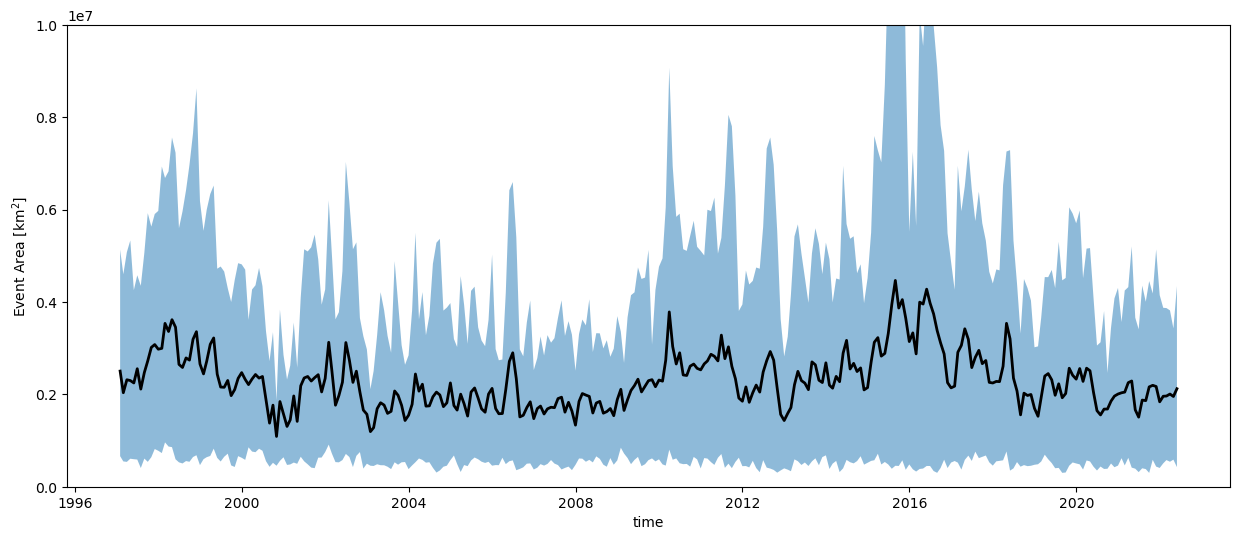

In [7]:
area = extreme_events_ds.area.chunk({'ID': 1000, 'time': 100})
area_mean = area.mean("ID").resample(time="ME").mean().compute()

area_quantiles = (area
                  .quantile([0.1, 0.9], dim="ID")
                  .resample(time="ME")
                  .mean()).compute()

area_10 = area_quantiles.sel(quantile=0.1)
area_90 = area_quantiles.sel(quantile=0.9)

plt.figure(figsize=(15, 6))
area_mean.plot(label="Mean Area", color="k", lw=2)
plt.fill_between(area_mean.time.values, area_10, area_90, alpha=0.5)
plt.ylim([0, 1e7])
plt.ylabel(r"Event Area [km$^2$]");

## Hovmüller Plot of MHW Monthly Frequency vs Latitude

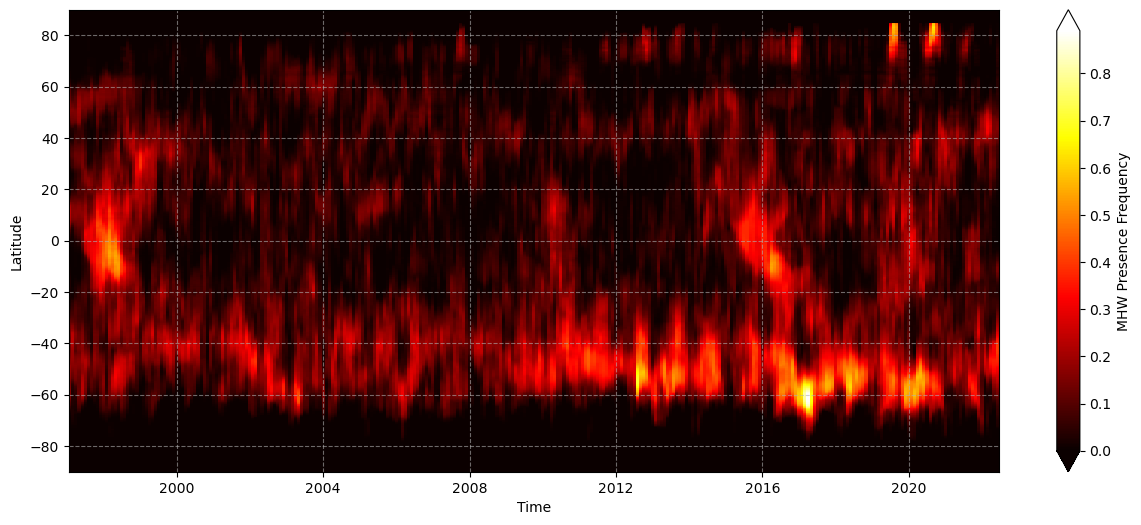

In [8]:
spatial_presence = (ID_field > 0).mean(dim="lon").resample(time="ME").mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence.plot(
    ax=ax,
    cmap="hot",
    x="time",
    cbar_kwargs={"label": "MHW Presence Frequency", "extend": "both"},
)

ax.set_xlabel("Time")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.6)

## Seasonal Cycle of MHW vs Latitude

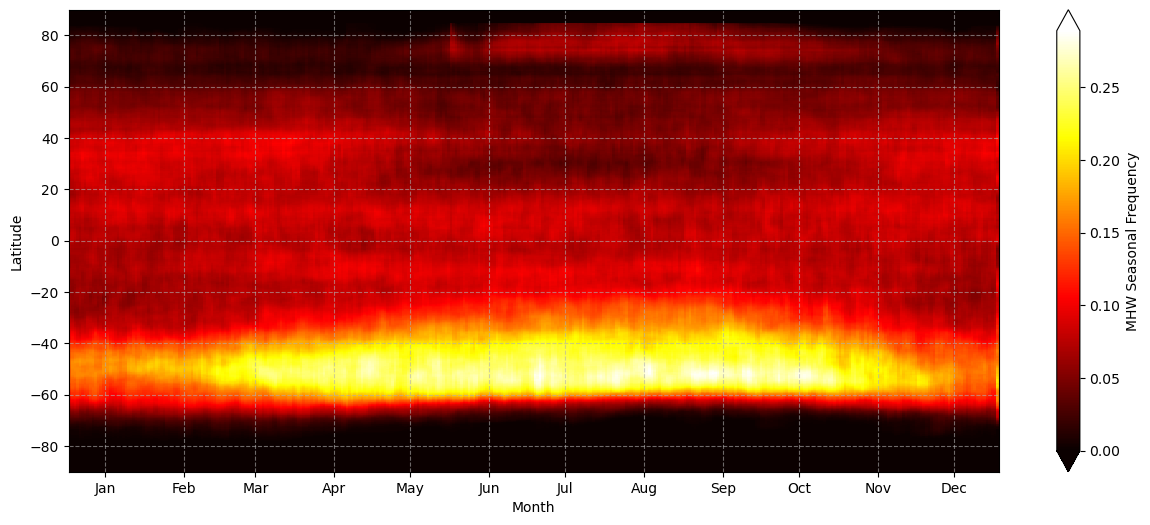

In [9]:
spatial_presence_seasonal = (ID_field > 0).mean(dim="lon").groupby("time.dayofyear").mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence_seasonal.plot(
    ax=ax,
    cmap="hot",
    x="dayofyear",
    cbar_kwargs={"label": "MHW Seasonal Frequency", "extend": "both"},
)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_positions = np.cumsum([0] + days_per_month[:-1]) + 15

ax.set_xticks(month_positions)
ax.set_xticklabels(months)
ax.set_xlabel("Month")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.6)